In [1]:
!python -V

Python 3.9.23


In [2]:
import sys
print(sys.executable)

/home/codespace/anaconda3/envs/exp-tracking-env/bin/python


In [3]:
import pandas as pd 

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/08/26 10:42:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/26 10:42:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/MLOps/02-experiment-tracking/mlruns/1', creation_time=1756198980276, experiment_id='1', last_update_time=1756198980276, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet')

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [10]:
df.shape


(3475226, 20)

In [11]:
# Use only 100k rows for training (enough to test pipeline)
df_sample = df.sample(n=50000, random_state=42)
# Ensure datetime conversion
df_sample.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(df_sample['tpep_dropoff_datetime'])
df_sample.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(df_sample['tpep_pickup_datetime'])

# Duration in minutes (vectorized, no apply)
df_sample.loc[:, 'duration'] = (df_sample['tpep_dropoff_datetime'] - df_sample['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter rows (returns a copy, so reassign)
df_sample = df_sample.loc[(df_sample['duration'] >= 1) & (df_sample['duration'] <= 60)].copy()

# Cast categorical
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_sample.loc[:, categorical] = df_sample[categorical].astype(str)



/tmp/ipykernel_61666/332740928.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['238' '50' '236' ... '237' '79' '125']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_sample.loc[:, categorical] = df_sample[categorical].astype(str)
/tmp/ipykernel_61666/332740928.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['166' '48' '237' ... '263' '144' '148']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_sample.loc[:, categorical] = df_sample[categorical].astype(str)


In [12]:


train_dicts = df_sample[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df_sample['duration'].values


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

57.82552788174207

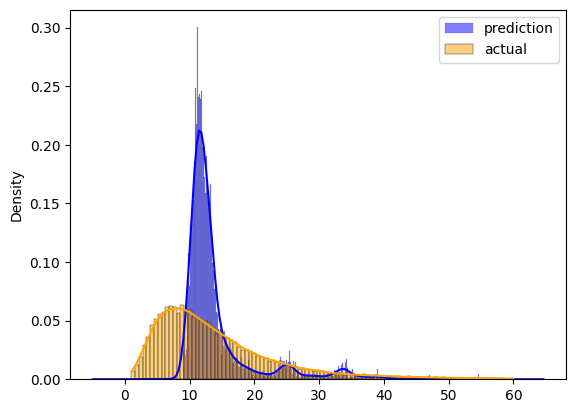

In [13]:
sns.histplot(y_pred, label='prediction', color='blue', kde=True, stat="density")
sns.histplot(y_train, label='actual', color='orange', kde=True, stat="density")
plt.legend()


In [14]:
cols = [
    "tpep_pickup_datetime", 
    "tpep_dropoff_datetime", 
    "PULocationID", 
    "DOLocationID", 
    "trip_distance"
]

df = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet",
    columns=cols
)
print(df.head())

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
print("Converted datetimes ✅")

# Compute duration
df['duration'] = (
    (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
    .dt.total_seconds() / 60
)

df = df[
    (df['duration'] >= 1) &
    (df['duration'] <= 60)
].copy()
df[['PULocationID','DOLocationID']] = df[['PULocationID','DOLocationID']].astype(str)
print("Categorical converted ✅")


  tpep_pickup_datetime tpep_dropoff_datetime  PULocationID  DOLocationID  \
0  2025-01-01 00:18:38   2025-01-01 00:26:59           229           237   
1  2025-01-01 00:32:40   2025-01-01 00:35:13           236           237   
2  2025-01-01 00:44:04   2025-01-01 00:46:01           141           141   
3  2025-01-01 00:14:27   2025-01-01 00:20:01           244           244   
4  2025-01-01 00:21:34   2025-01-01 00:25:06           244           116   

   trip_distance  
0           1.60  
1           0.50  
2           0.60  
3           0.52  
4           0.66  
Converted datetimes ✅


: 

In [ ]:
def read_dataframe(filename):
    cols = [
        "tpep_pickup_datetime", 
        "tpep_dropoff_datetime", 
        "PULocationID", 
        "DOLocationID", 
        "trip_distance"
    ]

    if filename.endswith('.csv'):
        df = pd.read_csv(filename, usecols=cols)

    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename, columns=cols)

    else:
        raise ValueError("Unsupported file format: must be .csv or .parquet")

    # Convert to datetime
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

    # Duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Filter reasonable trips
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)].copy()

    # Categorical columns as string
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


: 

In [ ]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet').sample(100000, random_state=42)
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet').sample(50000, random_state=42)

In [ ]:
len(df_train), len(df_val)

(100000, 50000)

In [ ]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

31.371748282094934

In [ ]:
import os
import pickle

# Make sure folder exists
os.makedirs("models", exist_ok=True)

# Save model + vectorizer
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Sidhu")
    mlflow.log_param("train_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")
    mlflow.log_param("test_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("mse", mse)

NameError: name 'mlflow' is not defined